In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

%matplotlib inline

def pmin(data):
    print(data.dtype, end=' ')
    print(type(data), end=' ')
    if isinstance(data, np.ndarray):
        print(data.shape)
    print()

# Sine Wave Model

In [2]:
# https://stackoverflow.com/questions/13897316/approximating-the-sine-function-with-a-neural-network
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 300, 1
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model
class TheModelClass(nn.Module):
    def __init__(self, D_in=1, H=10, D_out=1):
        super(TheModelClass, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass(D_in, H, D_out).to(device=device)
    
# Use the nn package to define our model and loss function.
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# )

model.eval()

loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

cpu
Model's state_dict:
fc1.weight 	 torch.Size([300, 1])
fc1.bias 	 torch.Size([300])
fc2.weight 	 torch.Size([300, 300])
fc2.bias 	 torch.Size([300])
fc4.weight 	 torch.Size([300, 300])
fc4.bias 	 torch.Size([300])
fc3.weight 	 torch.Size([1, 300])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140566380295800, 140566380295872, 140566380295944, 140566380296016, 140566380296160, 140566380296232, 140566380296304, 140566380296376]}]


In [3]:
# for t in range(25000):
for t in tqdm(range(50000)):
    # gen random data
    Xin = np.random.randint(360*3, size=1000).reshape(1000,1)
    Yout = np.sin(np.deg2rad(Xin))
    
    x = torch.tensor(Xin, dtype=dtype, device=device)

    y = torch.tensor(Yout, dtype=dtype, device=device)
#     print(np.min(y.cpu().numpy()))
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
#     if t%1000==0:
#         print(t, loss.item())
    loss_history.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

plt.plot(loss_history)

  2%|▏         | 857/50000 [00:19<24:51, 32.96it/s] 

KeyboardInterrupt: 

torch.Size([1000, 1])


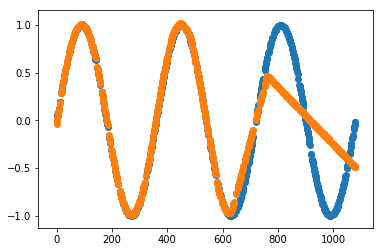

In [9]:
X_test = np.random.randint(360*3, size=1000).reshape(1000,1)
Y_test = np.sin(np.deg2rad(X_test))
y_pred = model(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

In [13]:
# save model
torch.save(model.state_dict(), 'sinNN')

#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [6]:
# load model
model_sin = TheModelClass(D_in, H, D_out).to(device=device)

# model_P = TheModelClass(*args, **kwargs)
model_sin.load_state_dict(torch.load('sinNN'))
model_sin.eval()

TheModelClass(
  (fc1): Linear(in_features=1, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

torch.Size([1000, 1])


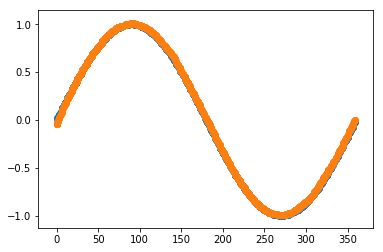

In [7]:
X_test = np.random.randint(360, size=1000).reshape(1000,1)
Y_test = np.sin(np.deg2rad(X_test))
y_pred = model_sin(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

# for n in range(X_test.shape[0]):
#     print(n, X_test[n], Y_test[n, 0], y_pred[n].item())

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

# Cos Model

In [15]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 1, 300, 1
dtype = torch.float
device = torch.device('cuda:0')

# Define model
class TheModelClass(nn.Module):
    def __init__(self, D_in=1, H=10, D_out=1):
        super(TheModelClass, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc4 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass(D_in, H, D_out).to(device=device)
model.eval()
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([300, 1])
fc1.bias 	 torch.Size([300])
fc2.weight 	 torch.Size([300, 300])
fc2.bias 	 torch.Size([300])
fc4.weight 	 torch.Size([300, 300])
fc4.bias 	 torch.Size([300])
fc3.weight 	 torch.Size([1, 300])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140154804983704, 140154804983848, 140154804982264, 140154804983992, 140154804983416, 140154804983560, 140154804983272, 140154804982048]}]


100%|██████████| 50000/50000 [02:02<00:00, 407.64it/s]


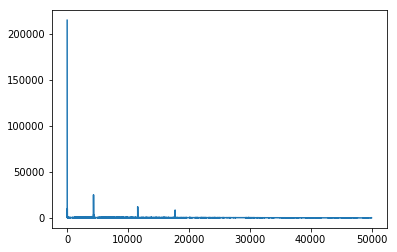

In [4]:
for t in tqdm(range(50000)):
    # gen random data
    Xin = np.random.randint(360*3, size=1000).reshape(1000,1)
    Yout = np.cos(np.deg2rad(Xin))
    x = torch.tensor(Xin, dtype=dtype, device=device)
    y = torch.tensor(Yout, dtype=dtype, device=device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    loss_history.append(loss.item())

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

plt.plot(loss_history)

torch.Size([1000, 1])


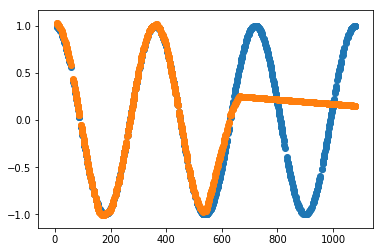

In [5]:
X_test = np.random.randint(360*3, size=1000).reshape(1000,1)
Y_test = np.cos(np.deg2rad(X_test))
y_pred = model(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

In [6]:
# save model
torch.save(model.state_dict(), 'cosNN')

#https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [3]:
# load model
model_cos = TheModelClass(D_in, H, D_out).to(device=device)

# model_P = TheModelClass(*args, **kwargs)
model_cos.load_state_dict(torch.load('cosNN'))
model_cos.eval()

TheModelClass(
  (fc1): Linear(in_features=1, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

(1000, 1)
torch.Size([1000, 1])


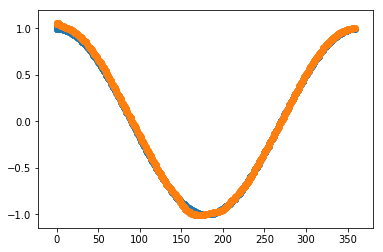

In [20]:
X_test = np.random.randint(360, size=1000).reshape(1000,1)
print(X_test.shape)
Y_test = np.cos(np.deg2rad(X_test))
y_pred = model_cos(torch.tensor(X_test, dtype=dtype, device=device))
print(y_pred.shape)

# for n in range(X_test.shape[0]):
#     print(n, X_test[n], Y_test[n, 0], y_pred[n].item())

plt.scatter(X_test, Y_test)
plt.scatter(X_test, y_pred.cpu().data)

# Forward Kinematics

In [9]:
def visual(point_start, point_elbow, point_end, connections = False):
    point_start = (0, 0)
    if connections:
        x = np.array([point_start[0], point_elbow[0], point_end[0]])
        y = np.array([point_start[1], point_elbow[1], point_end[1]])
        plt.plot(x, y)
    plt.plot(point_start[0], point_start[1], 'ko')
    plt.plot(point_elbow[0], point_elbow[1], 'ro')
    plt.plot(point_end[0], point_end[1], 'bo')
    plt.xlim([-11, 11])
    plt.ylim([-11, 11])
    plt.title('2D Robot Arm')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')

In [13]:
point_start = (0, 0) #(x, y)
point_elbow = (0, 5)
point_hand = (0, 10)

L1 = 5
L2 = 5

alpha = np.array([0, 30, 60, 90])
beta = np.array([0, 30, 60, 90])

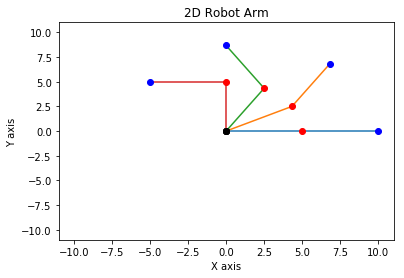

In [53]:
# trigonometry
def getHandPoint(alpha, beta, L1=1, L2=1):
    x = L1*np.cos(np.deg2rad(alpha)) + L2*np.cos(np.deg2rad(alpha+beta))
    y = L1*np.sin(np.deg2rad(alpha)) + L2*np.sin(np.deg2rad(alpha+beta))
    return (x, y)

def getElbowPoint(alpha, L1=1):
    x = L1*np.cos(np.deg2rad(alpha))
    y = L1*np.sin(np.deg2rad(alpha))
    return (x, y)

Xe, Ye = getElbowPoint(alpha, L1)
Xh, Yh = getHandPoint(alpha, beta, L1, L2)

elbow = []
hand = []
for n in range(Xh.shape[0]):
    elbow.append((Xe[n], Ye[n]))
    hand.append((Xh[n], Yh[n]))

for n in range(len(elbow)):
    visual(point_start, elbow[n], hand[n], True)

In [44]:
print(Xe.reshape(1, Xe.shape[0]))
print(Ye.reshape(1, Ye.shape[0]))

print(Xh.reshape(1, Xh.shape[0]))
print(Yh.reshape(1, Yh.shape[0]))

[[5.00000000e+00 4.33012702e+00 2.50000000e+00 3.06161700e-16]]
[[0.         2.5        4.33012702 5.        ]]
[[ 1.00000000e+01  6.83012702e+00  1.33226763e-15 -5.00000000e+00]]
[[0.         6.83012702 8.66025404 5.        ]]


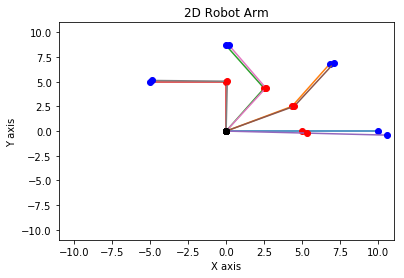

In [54]:
# NN
def getHandPointNN(alpha, beta, L1=1, L2=1):
    x = L1*model_cos(torch.tensor(alpha, dtype=dtype, device=device)) + L2*model_cos(torch.tensor(alpha+beta, dtype=dtype, device=device))
    y = L1*model_sin(torch.tensor(alpha, dtype=dtype, device=device)) + L2*model_sin(torch.tensor(alpha+beta, dtype=dtype, device=device))
    return (x.cpu().detach().numpy(), y.cpu().detach().numpy())

def getElbowPointNN(alpha, L1=1):
    x = L1*model_cos(torch.tensor(alpha, dtype=dtype, device=device))
    y = L1*model_sin(torch.tensor(alpha, dtype=dtype, device=device))
    return (x.cpu().detach().numpy(), y.cpu().detach().numpy())

Xen, Yen = getElbowPointNN(alpha.reshape(alpha.shape[0],1), L1)
Xhn, Yhn = getHandPointNN(alpha.reshape(alpha.shape[0],1), beta.reshape(alpha.shape[0],1), L1, L2)

# elbow = []
# hand = []
for n in range(Xhn.shape[0]):
    elbow.append((Xen[n], Yen[n]))
    hand.append((Xhn[n], Yhn[n]))

for n in range(len(elbow)):
    visual(point_start, elbow[n], hand[n], True)

In [42]:
print(Xen)
print(Yen)

print(Xhn)
print(Yhn)

[[5.289333   4.4833937  2.6112306  0.07970926]]
[[-0.20470262]
 [ 2.517624  ]
 [ 4.359717  ]
 [ 5.0438824 ]]
[[10.578666  ]
 [ 7.0946245 ]
 [ 0.16363621]
 [-4.899085  ]]
[[-0.40940523]
 [ 6.877341  ]
 [ 8.733971  ]
 [ 5.1212616 ]]


In [52]:
mse = np.mean((Xe - Xen.T)**2 + (Ye - Yen.T)**2 + (Xh - Xhn.T)**2 + (Yh - Yhn.T)**2)
print(mse)

0.20067471672693926


# TrigNN Class

In [1]:
from TrigNN import TrigModel
import numpy as np

In [2]:
TrigM = TrigModel()

In [3]:
SinNN = TrigM.Sin()
CosNN = TrigM.Cos()

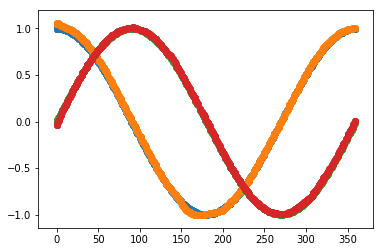

In [5]:
# temp
import matplotlib.pyplot as plt

X_test = np.random.randint(360, size=1000).reshape(1000,1)

Y_cos = np.cos(np.deg2rad(X_test))
Y_cos_pred = CosNN(TrigM.toTorchTensor(X_test))

Y_sin = np.sin(np.deg2rad(X_test))
Y_sin_pred = SinNN(TrigM.toTorchTensor(X_test))

plt.scatter(X_test, Y_cos)
plt.scatter(X_test, TrigM.toNumpy(Y_cos_pred))

plt.scatter(X_test, Y_sin)
plt.scatter(X_test, TrigM.toNumpy(Y_sin_pred))
plt.show()